# Accessing JRSRP Fractional Cover Datasets on TERN

Author: Rebecca Trevithick

Contact: rebecca.trevithick@des.qld.gov.au

Aims of this notebook are:
-  Provide useful links to JRSRP Fractional Cover products and VegMachine
-  Provide code examples for:
    - obtaining file listings from TERN
    - extracting timeseries data
    - displaying an array
    - downloading subset of a COG

## Available Datasets

All JRSRP/QLD Remote Sensing Centre mosaics are publically available from two locations on the Terrestrial Ecosystem Research Network (TERN) infrastructure as cloud optimised geotiffs (COGS):
-  https://data.tern.org.au/rs/public/data/remote-sensing/
-  http://qld.auscover.org.au/public/data/remote-sensing/

These two sites contain the same datasets, however the file structure varies slightly. Occasionally it is useful to know both addresses in the event that one site is temporarily unavailable.

The data on the data.tern.org.au is also available via a THREDDS server, which is the address located on the various products metadata pages. Many people are not comfortable using the varioius THREDDS server options, so this notebook focuses solely on accessing the COGS via HTTP. 

There are considerable fractional cover datasets produced. These include the original fractional cover datasets for Landsat and Sentinel at monthly and seasonal timesteps, as well as numerous derived products. Metadata is available for all the products at https://portal.tern.org.au/. Some of the primary ones are listed below:

| Dataset | Temporal Frequency | Metadata | 
|---|---|---|
|**Fractional Cover V2** |||
| Landsat FC | Seasonal |  https://portal.tern.org.au/seasonal-fractional-cover-australia-coverage/22026 |
| Sentinel FC| Seasonal | https://portal.tern.org.au/seasonal-fractional-cover-australia-coverage-22023/22023|
| Blended Sentinel/Landat FC| Monthly | https://portal.tern.org.au/monthly-blended-fractional-queensland-coverage/22024 | 
| **Derived Datasets** |
| Landsat Persistent Green | Seasonal | https://portal.tern.org.au/seasonal-persistent-green-australia-coverage/22025 |
| Landsat Ground Cover | Seasonal |  https://portal.tern.org.au/seasonal-ground-cover-australia-coverage/22022 |
| **Fractional Cover V3** |
| Landsat FC | Seasonal | https://portal.tern.org.au/seasonal-fractional-cover-australia-coverage-23880/23880 |
| Sentinel FC| Seasonal | https://portal.tern.org.au/seasonal-fractional-cover-australia-coverage-23881/23881|

There are numerous other Fractional Cover derived datasets available that are not listed here including: 
 -  Long term statistics
 -  Dynamic reference
 -  Decile products
A simple google search or search on the TERN portal should lead you to the metadata for these products.

## VegMachine

VegMachine is a Web Application designed to assist with extracting timeseries data from the various Fractional Cover datasets present on TERN. VegMachine is ideal for a quick analysis of the cover history of a site defined by a polygon, but has a fair amount of manual overhead for regular monitoring or large numbers of polygons. 

http://vegmachine.net

## Import Necessary Libraries

In [76]:
import os
from urllib.parse import urlparse 

import requests
from bs4 import BeautifulSoup
import numpy as np
import rasterio as rio
from rasterio import mask
from rasterio import warp

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

## Get Directory Listings from TERN

Directory listings can be obtained from the servers through web scraping. All our mosaic files are delivered as cloud optimised geotiffs (COGs), so you will only need to earch for files that end in 'tif' to get the full listing. The following function allows you to scrape the http sever folder for the COGS given a url to the directory.

In [77]:
def get_url_paths(url, ext='tif', params={}):
    """
    Get list of urls for http server address
    
    :param url: url of the page containing the required COGs 
    :param ext: file ext to search for - defaults to 'tif' for COGs 
    :param params: request parameters - optional
    :return: list of individual COG paths
    """
    response = requests.get(url, params=params)
    if response.ok:
        response_text = response.text
    else:
        return response.raise_for_status().path
    soup = BeautifulSoup(response_text, 'html.parser')
    hrefs = [node.get('href') for node in soup.find_all('a')]
    paths = [os.path.join(os.path.dirname(url).replace('catalog','fileServer'), os.path.basename(href)) for href in hrefs if href.endswith(ext)]
    return paths


We can obtain a list of seasonal fractional cover for QLD by running this function and passing in the url to the folder containing the tifs.

In [78]:
seasonal_fc3_cogs = "http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover_v3/fractional_cover/seasonal/qld/"
qld_fc3_files = get_url_paths(seasonal_fc3_cogs)
print(qld_fc3_files[:3])

['http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover_v3/fractional_cover/seasonal/qld/lztmre_qld_m198712198802_dp1a2.tif', 'http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover_v3/fractional_cover/seasonal/qld/lztmre_qld_m198803198805_dp1a2.tif', 'http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover_v3/fractional_cover/seasonal/qld/lztmre_qld_m198806198808_dp1a2.tif']


## Preview Tiffs 

In [79]:
filepath = qld_fc3_files[0]
with rio.open(filepath) as src:
    #print(src.profile.__dict__)
    print('nodata: ', src.profile['nodata'])
    print('no of bands: ', src.profile['count'])
    print('crs: ', src.profile['crs'])
    print('transform: ', src.profile['transform'])

nodata:  255.0
no of bands:  3
crs:  EPSG:3577
transform:  | 30.00, 0.00, 404205.00|
| 0.00,-30.00,-1006985.00|
| 0.00, 0.00, 1.00|


We can quickly display the Tiff in the notebook using the overviews

[4, 8, 16, 32, 64, 128, 256, 510]


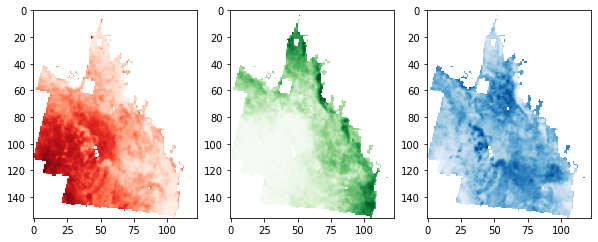

In [80]:
filepath = qld_fc3_files[0]
with rio.open(filepath) as src:
   overview_factors = src.overviews(1) # parameter is band number indexed from 1
   print(overview_factors) # list of overview decimation factors available - higher number lower resolution
   overview_factor = overview_factors[-1] # displaying last overview as the smallest
   out_shape = (int(src.height / overview_factor), int(src.width / overview_factor))
    
   bare = src.read(1, out_shape=out_shape)
   green = src.read(2, out_shape=out_shape)
   dry = src.read(3, out_shape=out_shape)
       
# using the variable axs for multiple Axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,7))   
    
# Plot overviews
bare_masked = np.ma.masked_where(bare >= 100, bare)
ax1.imshow(bare_masked, cmap='Reds')

green_masked = np.ma.masked_where(green >= 100, green)
ax2.imshow(green_masked, cmap='Greens')

dry_masked = np.ma.masked_where(dry >= 100, dry)
ax3.imshow(dry_masked, cmap='Blues')
plt.show()

In [81]:
def extract_ts_data(filelist, geometry, band, nodata):
    """
    Extract timeseries data for a provided geometry and list of files

    :param filelist: List of url strings 
    :param geometry: geometry
    :param band: band to extract data, indexed from 1
    :return: dictionary of masked numpy arrays with date key
    """
    # Get information on first geotiff file 
    with rio.open(filelist[0]) as src:
        crs = src.profile['crs']
    new_geom = geometry.to_crs(crs)
    
    fc_dict = {}
    for filepath in filelist:
        filename = os.path.basename(filepath)
        date = filename.split('_')[2] # Date is the third component of the filename for TERN fractional cover products. 
                                      # For seasonal timeseries it is the 'm' followed by the start month and end month
        fc = rio.open(filepath)
        data, affine = mask.mask(fc, new_geom, crop=True) # function returns both data and affine information
        band_data = data[band]
        fc_dict[date] = band_data[band_data != nodata]
    return fc_dict

In [82]:
#aoi = gpd.read_file('./polygons.geojson') # Usual geopandas method for importing a vector file into a geopandas dataframe

# Hardwired geometry for workshop example
wkts = ['POLYGON ((143.96 -21.30, \
                   143.97 -21.30, \
                   143.97 -21.31, \
                   143.96 -21.31, \
                   143.96 -21.30))'] 
# convert hardwired geometry into geopandas dataframe. Input into from_wkt method is required to be a list.
aoi = gpd.GeoSeries.from_wkt(wkts).set_crs('epsg:4326') # geometry needs to have crs defined

# Get geometry from geopandas dataframe 
coords = aoi.geometry

In [83]:
# Fractional Cover
last_n_images = 40 # restricting the dates to last 40 seasons
# band to extract indexed from 0 - for fractional cover 0 is bare, 1 is green, 2 is dry
bare = extract_ts_data(qld_fc3_files[-last_n_images:], coords, 0, 255) # bare is band 0
green = extract_ts_data(qld_fc3_files[-last_n_images:], coords, 1, 255) # green is band 1
dry = extract_ts_data(qld_fc3_files[-last_n_images:], coords, 2, 255) # dry is band 2

## Calculate a Statistic on Timeseries Arrays


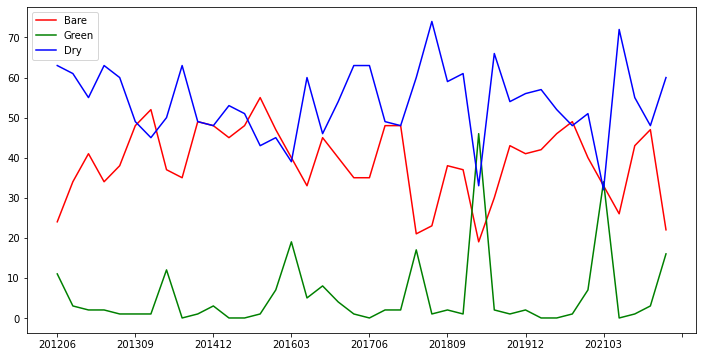

In [84]:
#Use a dictionary comprehension to calculate statistic for each array
# Calculating the average for each array, but could calculate any spatial statistic
bare_dict = {date[1:7]:round(np.mean(bare[date])) for date in bare} 
green_dict = {date[1:7]:round(np.mean(green[date])) for date in green}
dry_dict = {date[1:7]:round(np.mean(dry[date])) for date in dry}
## Create Timeseries Plots
# Create a dataframe for each dataset
bare_timeseries = pd.DataFrame.from_dict(bare_dict, orient="index")
green_timeseries = pd.DataFrame.from_dict(green_dict, orient="index")
dry_timeseries = pd.DataFrame.from_dict(dry_dict, orient="index")

ax = bare_timeseries.plot(figsize=(12,6), color='r') 
green_timeseries.plot(ax=ax, color='g')
dry_timeseries.plot(ax=ax, color='b')
ax.legend(["Bare", "Green", "Dry"])

## Download an Image Extract

In [85]:
new_coords = coords.to_crs('epsg:3577')
bounds = new_coords.bounds.values[0]
cmd = "gdal_translate -projwin {} {} {} {} -projwin_srs EPSG:3577 \
/vsicurl/{} example.tif".format(bounds[0], bounds[3], bounds[2], bounds[1], qld_fc3_files[0])
os.system(cmd)

Input file size is 63186, 80040
0...10...20...30...40...50...60...70...80...90...100 - done.


0